# Cargar paquetes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Leer archivos

In [3]:
trozoC = pd.read_csv("TrozoC.txt", names=["LP", "VD"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")

In [39]:
"""trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "Time"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")"""

'trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "Time"], \n                     delimiter="\t", skiprows = range(3), \n                     index_col=False, decimal=",")'

In [38]:
"""trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")"""

'trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], \n                     delimiter="\t", skiprows = range(3), \n                     index_col=False, decimal=",")'

In [40]:
trozoC.head()

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


# Establecer umbral

In [41]:
# Estrategia 1: umbral a 1.5 * rango intercuartílico
#threshold = (trozoC.quantile(0.75)-trozoC.quantile(0.25))*1.5

# Estrategia 2: umbral a media + 2 * desviación típica (donde se concentra ~95% de probabilidad de una normal)
threshold = trozoC[trozoC>=0].mean() + 2*trozoC[trozoC>=0].std()

In [42]:
def filter_with_threshold(df, threshold):
    return (df > threshold).astype(int)

In [43]:
trozoC_t = filter_with_threshold(trozoC, threshold)

El número de elementos que superan el umbral es:

In [44]:
trozoC_t.sum()

LP    309755
VD    230843
dtype: int64

In [45]:
def compare_signal_and_transformation(df, df_t, threshold):
    """
    Muestra dos señales `df` y `df_t` que tengan las mismas dimensiones.
    """
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        # Get peaks for each column
        axs[index].plot(df.iloc[:, index])
        axs[index].plot(df_t.iloc[:,index])
        axs[index].plot(threshold[index]*np.ones(df.shape[0]))

Al aplicar la función sobre la señal original y la transformada (aplicando un escalado) podemos observar qué valores quedan por encima del umbral. Probamos con los primeros 100 valores.

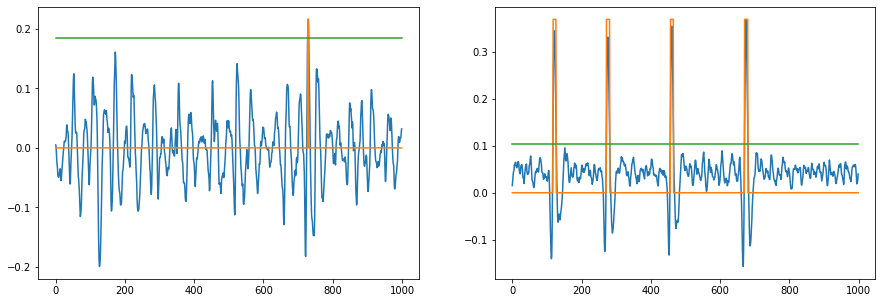

In [63]:
N=1000
compare_signal_and_transformation(trozoC[0:N], trozoC_t[0:N]*trozoC[0:N].max(), threshold)

# Calcular picos

In [48]:
def get_peaks(df):
    """
    Busca los picos correspondientes a cada columna del dataframe utilizando find_peaks. 
    Esta se queda con el valor medio de picos consecutivos.
    """
    # Get number of columns
    cols = df.shape[1] if len(df.shape) > 1 else 1
    # Initialize peaks array
    return [find_peaks(df.iloc[: , index])[0] for index in range(cols)]

El número total de picos encontrados es:

In [49]:
peaks = get_peaks(trozoC_t)
for i in peaks:
    print(len(i))

50220
25439


Ejemplo 

In [50]:
def compare_signal_and_peaks(df, peaks):
    """
    Muestra la señal original junto con los picos considerados.
    """
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        # Get peaks for each column
        axs[index].plot(df.iloc[:, index])
        axs[index].plot(peaks[index], df.iloc[peaks[index], index], "o")

Mostramos un ejemplo en los 100 primeros valores.

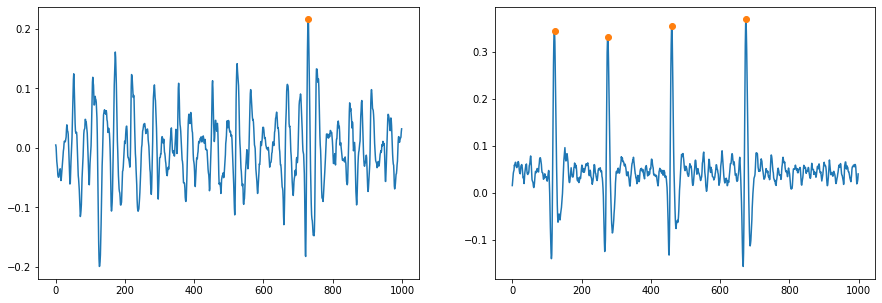

In [64]:
peaks = get_peaks(trozoC_t[0:N])
compare_signal_and_peaks(trozoC[0:N], peaks)

# Cómputo de información mutua

In [34]:
from sklearn.metrics import mutual_info_score as MI

Utilizamos la función de `sklearn`, la cual dados dos conjuntos de puntos discretos, calcula la información de las distribuciones discretas correspondientes como:
$$MI(U,V)=\sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \frac{|U_i\cap V_j|}{N}
\log\frac{N|U_i \cap V_j|}{|U_i||V_j|}$$

In [37]:
MI(trozoC_t["LP"], trozoC_t["VD"])

3.702359351459572e-07